# Image reconstruction from parallel projections

**Authors: M. Ravasi, D. Vargas, I. Vasconcelos**

Welcome to the last notebook of our **Solving large-scale inverse problems in Python with PyLops** tutorial!

The aim of this tutorial is to:

- experiement with the PyLops framework to setup non-trivial linear operators
- understand when and how we should try to leverage third-party code in the creation of a PyLops operator
- bring everything together in a (hopefully) familiar context - that of reconstruction of an image from a limited set of projections (aka Inverse Radon transform)

## Setting the scene

The problem of reconstructing an image from a limited set of projections is well-known problem in a variety of disciplines. Here we will specifically focus on *CT image reconstruction with parallel beam projections*.

Let's start from the **Fourier Slice Theorem** (Source: wikipedia https://en.wikipedia.org/wiki/Projection-slice_theorem):

<img src="figs/Fourier_Slice_Theorem.png" width="600">

In words, given a two-dimensional function (e.g., an image):

- project the image it onto a line, and do a Fourier transform of that projection.
- apply a two-dimensional Fourier transform of the image (i.e., compute its wavenumber spectrum), and then extract a slice through its origin, which is parallel to the projection line.

Based on the fact that physically we can only acquire projections $\mathbf{p}$, we can think about setting a variety of inverse problems:

1. Simply invert the projection operator: $\mathbf{p} = \mathbf{P} \mathbf{i}$
1. Fourier transform the projections and place them at their right location in the wavenumber spectrum and then invert the restricted ($\mathbf{R}$) two-dimensional Fourier transform ($\mathbf{K}$): $\mathbf{k} = \mathbf{R} \mathbf{K} \mathbf{i}$

To start we are going to quickly look at what *scikit-image* has to offer (https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html). We see that they provide a forward Radon and the classical Filtered Back Projection (FBP). 

- Can we use anything to create either of our forward modelling operators and then feed them to any of PyLops solvers?
- What about the adjoint?

Let's first import the libraries we need in this tutorial

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pylops
import scooby

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon

from pylops import FunctionOperator
from pylops.utils import dottest

We also import the famous Shepp Logan image that we will use in this tutorial.

Notice that we apply a zero pad the Shepp Logan phantom image. This will be required later on in the notebook, let's not care about it for the moment.

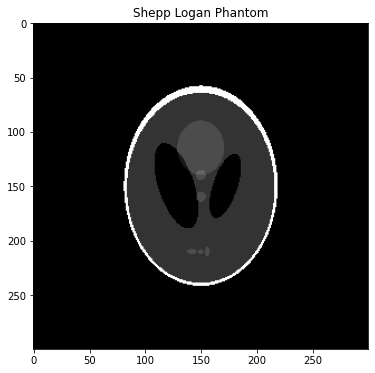

In [2]:
image = shepp_logan_phantom()[::2, ::2]

pad = 50
image = np.pad(image, ((pad, pad), (pad, pad)))

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Shepp Logan Phantom')
plt.axis('tight');

## scikit-image Radon

Let's start by using scikit-image ``radon`` functionality to see what we can do with them and also to set a benchmark

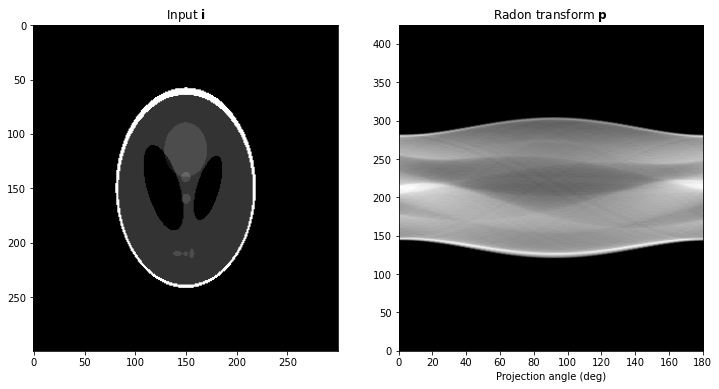

In [3]:
thetamin, thetamax, dtheta = 0, 180, 3
thetas = np.arange(thetamin, thetamax, dtheta)
projection = radon(image, theta=thetas, circle=False, preserve_range=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image, cmap='gray')
ax1.set_title(r"Input $\mathbf{i}$")
ax1.axis('tight')
ax2.imshow(projection, cmap='gray', extent=(0, 180, 0, projection.shape[0]))
ax2.set_title(r"Radon transform $\mathbf{p}$")
ax2.set_xlabel("Projection angle (deg)")
ax2.axis('tight');

We can now try to reconstruct our original image using ``iradon`` that is based on the famous Filtered Back Projection (FBP) algorithm, and we also compute the mean square error (MSE) of this reconstruction

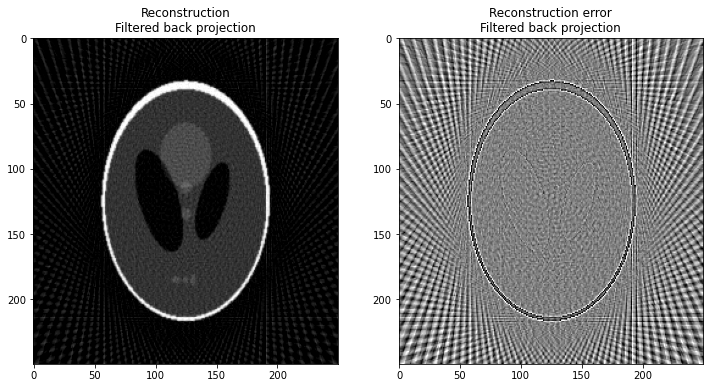

In [4]:
image_fbp = iradon(projection, theta=thetas, circle=False)
mse_fbp = np.linalg.norm(image_fbp[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image_fbp[pad//2:-pad//2, pad//2:-pad//2], cmap='gray', vmin=0, vmax=1)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.axis('tight')
ax2.imshow(image_fbp[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2], 
           cmap='gray', vmin=-0.2, vmax=0.2)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.axis('tight');

If we did not know exactly what ``radon``-``iradon`` does, we could have wondered whether they could be used directly as forward-adjoint pairs within a PyLops operator.

Let's try to see how can approach this using the ``FunctionOperator`` functionality in PyLops (https://pylops.readthedocs.io/en/latest/api/generated/pylops.FunctionOperator.html#pylops.FunctionOperator). We can then use our ``dottest`` to understand if this is an actual forward-adjoint pair.

In [5]:
# Forward
mvec = lambda x: radon(x.reshape(image.shape), theta=thetas, circle=False, preserve_range=False)

# Adjoint
rmvec = lambda x: iradon(x.reshape(projection.shape), theta=thetas, circle=False, filter=None, 
                         interpolation='nearest')
Fop = FunctionOperator(mvec, rmvec, projection.size, image.size)

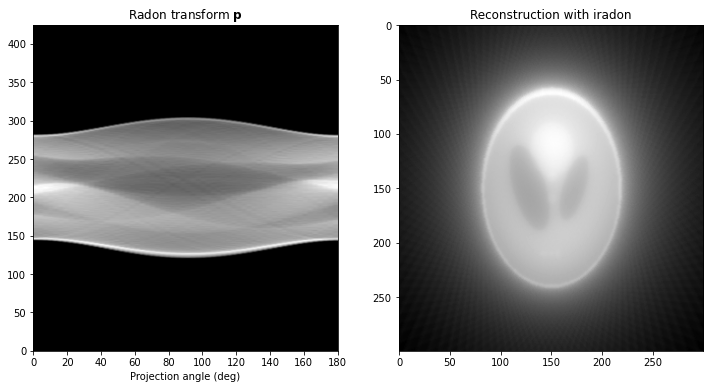

In [6]:
projection1 = Fop * image.ravel()
projection1 = projection.reshape(projection.shape)

image_adj = Fop.H * projection1.ravel()
image_adj = image_adj.reshape(image.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(projection, cmap='gray', extent=(0, 180, 0, projection.shape[0]))
ax1.set_title(r"Radon transform $\mathbf{p}$")
ax1.set_xlabel("Projection angle (deg)")
ax1.axis('tight')
ax2.imshow(image_adj, cmap='gray')
ax2.set_title("Reconstruction with iradon")
ax2.axis('tight');

In [7]:
#dottest(Fop, Fop.shape[0], Fop.shape[1])

Unfortunately as we suspected it, `iradon` even without the filter does not behave as the adjoint of `radon`.

Nevertheless, this excercise has been useful to see how we can quickly implement PyLops compatible linear operators using ``FunctionOperator``, something that is very useful to test out ideas when prototyping in notebooks.

## Radon with PyLops

Let's see if we can use any of PyLops operators to create an operator that mimics the ``radon`` of scikit-image. Provided this is possible, we would get automatically access to the adjoint of such an operator and can solve the inverse problem with any of our solvers (including those that allow adding sparsity to the solution).

In pseudocode the projection operator (1 in figure above) is simply a rotation and summation:

``
for each theta
    rotate image by theta
    sum over horizontal axis
``

and its adjoint would be something like

``
for each theta
    spread over horizontal axis
    rotate image by -theta
``

As rotation of an image is equivalent to performing an interpolation from the original unrotated grid to a new rotated grid, we can use PyLops ``Bilinear`` operator $\mathbf{B}$ (https://pylops.readthedocs.io/en/latest/api/generated/pylops.signalprocessing.Bilinear.html). And summing over horizonal lines in the new rotated grid, can be easily performed using the ``Sum`` operator $\mathbf{S}$ (https://pylops.readthedocs.io/en/latest/api/generated/pylops.Sum.html). We will need to repeat it for a certain $N_\theta$ angles: this is equivalent to vertically stacking the different operators. In mathematical terms our projection can be written as:

$$
\mathbf{P}=
\begin{bmatrix}
    \mathbf{S} \mathbf{B}_{\theta_0}   \\
    \mathbf{S} \mathbf{B}_{\theta_0}    \\
    ...  \\
    \mathbf{S} \mathbf{B}_{\theta_{N-1}} 
\end{bmatrix}
$$

First of all let's see how we can perform one rotation using the `Bilinear` operator. As shown in figure, we can simply identify the coordinates of each grid point after a rotation and use bilinear interpolation to interpolate the original grid into this new grid. 

Moreover to avoid some points to fall outside of the original grid we only perform the rotation for a portion of the grid inside the original one.

<img src="figs/Rotated_Grid.png" width="400">

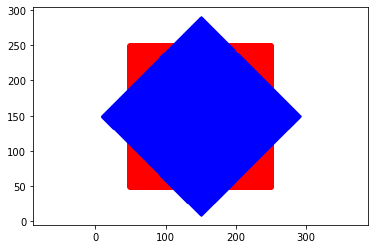

In [8]:
nx, ny = image.shape
inner = 100

# define axis for rotation via bilinear interpolation
x0, y0 = nx//2, ny//2
x = np.arange(nx - inner) - x0 + inner//2
y = np.arange(ny - inner) - y0 + inner//2
X, Y = np.meshgrid(x, y, indexing='ij')
X, Y = X.ravel(), Y.ravel()
XY = np.vstack((X, Y))

# rotate
theta = 45
theta = np.deg2rad(theta)
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])
XYrot = R @ XY

# recenter to positive axes
XY[0] += x0
XY[1] += y0

XYrot[0] += x0
XYrot[1] += y0

plt.figure()
plt.scatter(XY[0] , XY[1], c='r')
plt.scatter(XYrot[0], XYrot[1], c='b', s=2)
plt.axis('equal');

Create the rotation operator

In [9]:
Rop = pylops.signalprocessing.Bilinear(XYrot, dims=(nx, ny))

Rotate the image

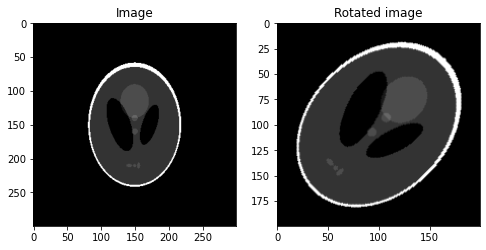

In [10]:
imagerot = Rop * image.ravel()
imagerot = imagerot.reshape(nx-inner, ny-inner)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.imshow(image, cmap='gray', vmin=0, vmax=1)
ax1.set_title("Image")
ax2.imshow(imagerot, cmap='gray', vmin=0, vmax=1)
ax2.set_title("Rotated image");

Let's now make an operator that applies $N_\theta$ repeated rotations and sums for all angles

In [11]:
def RadonRotate(dims, inner, thetas):
    # create original grid
    nx, ny = dims
    x0, y0 = nx//2, ny//2
    x = np.arange(nx - inner) - x0 + inner//2
    y = np.arange(ny - inner) - y0 + inner//2
    X, Y = np.meshgrid(x, y, indexing='ij')
    X, Y = X.ravel(), Y.ravel()
    XY = np.vstack((X, Y))

    thetas = np.deg2rad(thetas) # convert angles to radiants
    Rops = []
    for theta in thetas:
        # defined rotated coordinates
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        XYrot = R @ XY
        XYrot[0] += x0
        XYrot[1] += y0
        
        # create operator for current angle
        Rops.append(pylops.Sum(dims=(nx-inner, ny-inner), dir=0) * 
                    pylops.signalprocessing.Bilinear(XYrot, dims=(nx, ny)))
    # stack all operators together
    Radop = pylops.VStack(Rops)
    return Radop

We can now create our operator.

In [12]:
inner = 100
Radop = RadonRotate((nx, ny), inner, thetas)
print(Radop)

<12000x90000 VStack with dtype=float64>


Let's now compare the projection computed before with scikit-image with our one

In [13]:
projection1 = Radop * image.ravel()
projection1 = projection1.reshape(len(thetas), ny-inner)

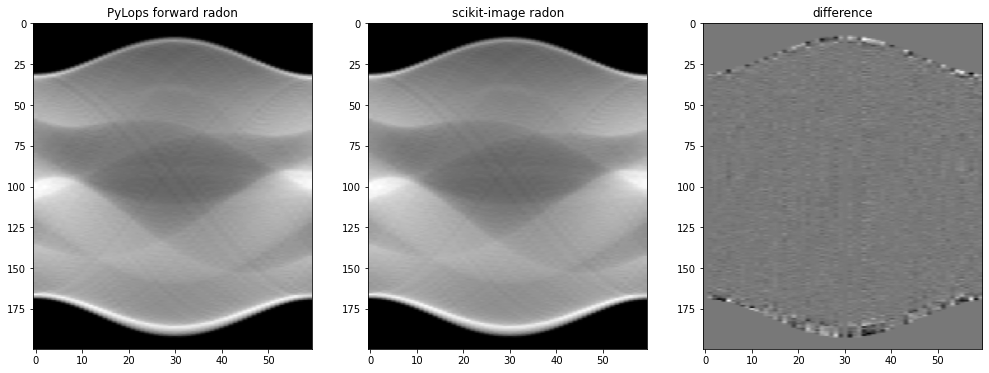

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 6))
ax1.imshow(projection1.T, cmap='gray')
ax1.set_title("PyLops forward radon")
ax1.axis("tight")
ax2.imshow(projection[projection.shape[0]//2-(nx-inner)//2:projection.shape[0]//2+(nx-inner)//2], cmap='gray')
ax2.set_title("scikit-image radon")
ax2.axis("tight")
ax3.imshow(projection1.T-projection[projection.shape[0]//2-(nx-inner)//2:projection.shape[0]//2+(nx-inner)//2], 
           cmap='gray')
ax3.set_title("difference")
ax3.axis("tight");

As you can see we have pretty much produced the same result but we have now something that has also a proper adjoint.

Let's see if we can now feed it into one of PyLops solvers. We will consider two cases:

- L2 regularized inversion: $J= ||\mathbf{p} - \mathbf{P} \mathbf{i}||_2^2 + ||\nabla \mathbf{i}||_2^2$
- TV regularized inversion: $J= ||\mathbf{p} - \mathbf{P} \mathbf{i}||_2^2 + ||\mathbf{D}_x  \mathbf{i}||_1 + ||\mathbf{D}_y \mathbf{i}||_1$

The first inversion can be easily carried out using PyLops ``RegularizedInversion`` (https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.leastsquares.RegularizedInversion.html) which allows including a number of L2 regularization terms to the main functional

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 102000 rows and 90000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.062e+03  3.062e+03    1.0e+00  3.2e-02
     1  0.00000e+00   9.013e+02  9.013e+02    2.9e-01  3.7e-01   1.0e+02  1.0e+00
     2  0.00000e+00   5.495e+02  5.495e+02    1.8e-01  2.8e-01   1.2e+02  2.6e+00
     3  0.00000e+00   3.963e+02  3.963e+02    1.3e-01  2.3e-01   1.3e+02  4.2e+00
     4  0.00000e+00   2.884e+02  2.884e+02    9.4e-02  1.9e-01   1.4e+02  6.0e+00
     5  0.00000e+00   2.010e+02  2.010e+02    6.6e-02  1.8e-01   1.5e+02  8.1e+00
     6  0.00000e+00   1.552e+02  1.552e+02    5.1e-02  1.6e-01   1.5e+02  9.9e+00
     7  0.00000e+00   1.046e+02  1.046e+02    3.4e-02  1.3e-01   1.6e+02  1.2e+01
     8  0.00000e+00   6.666e+01

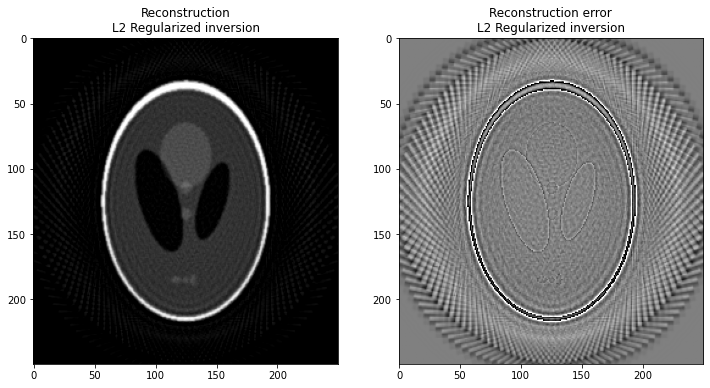

In [15]:
# Define laplacian
D2op = pylops.Laplacian(dims=(nx, ny), edge=True, dtype=np.float)

# Solve inverse problem
image_l2 = pylops.optimization.leastsquares.RegularizedInversion(Radop, [D2op], 
                                                                 projection1.ravel(), 
                                                                 epsRs=[1e0], show=True,
                                                                 **dict(iter_lim=20))
image_l2 = np.real(image_l2.reshape(nx, ny))
mse_l2 = np.linalg.norm(image_l2[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2], cmap='gray', vmin=0, vmax=1)
ax1.set_title("Reconstruction\nL2 Regularized inversion")
ax1.axis('tight')
ax2.imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2], 
           cmap='gray', vmin=-0.2, vmax=0.2)
ax2.set_title("Reconstruction error\nL2 Regularized inversion")
ax2.axis('tight');

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 12000 rows and 90000 cols
niter_outer =   5     niter_inner =   1   tol = 1.00e-04
mu = 2.00e-01         epsL1 = [1.0, 1.0]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   0.00000e+00        1.064e+02        3.702e+03
     2   0.00000e+00        3.390e+01        3.602e+03
     3   0.00000e+00        7.969e+01        3.368e+03
     4   0.00000e+00        1.142e+02        2.890e+03
     5   0.00000e+00        8.937e+01        2.489e+03

Iterations = 5        Total time (s) = 80.94
---------------------------------------------------------



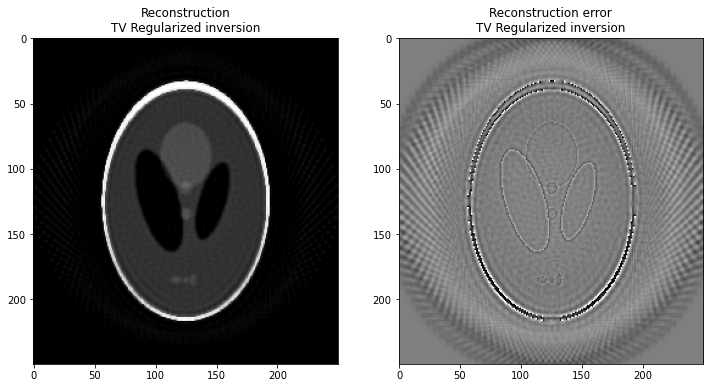

In [16]:
# Define first derivative operators
Dop = [pylops.FirstDerivative(ny*nx, dims=(nx, ny), dir=0, edge=True, kind='backward', dtype=np.float),
       pylops.FirstDerivative(ny*nx, dims=(nx, ny), dir=1, edge=True, kind='backward', dtype=np.float)]

# Solve inverse problem
mu = 0.2
lamda = [1., 1.]
niter = 5
niterinner = 1

image_tv, niter = pylops.optimization.sparsity.SplitBregman(Radop, Dop, projection1.ravel(), niter, niterinner,
                                                            mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=True,
                                                            **dict(iter_lim=10, damp=1e-2))
image_tv = np.real(image_tv.reshape(nx, ny))
mse_tv = np.linalg.norm(image_tv[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2], cmap='gray', vmin=0, vmax=1)
ax1.set_title("Reconstruction\nTV Regularized inversion")
ax1.axis('tight')
ax2.imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2], 
           cmap='gray', vmin=-0.2, vmax=0.2)
ax2.set_title("Reconstruction error\nTV Regularized inversion")
ax2.axis('tight');

Let's visualize the diffferent reconstructions all together

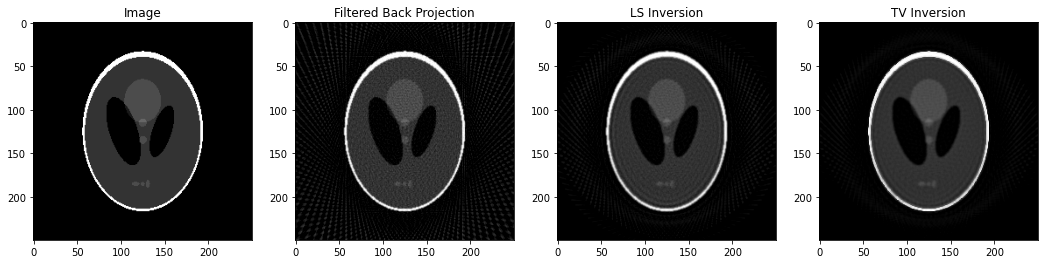

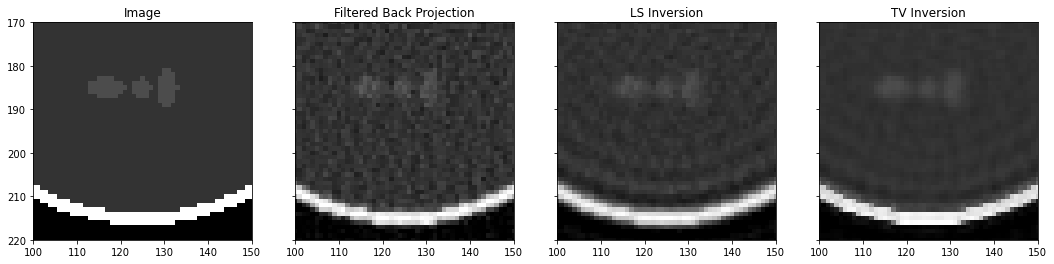

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
axs[0].imshow(image[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Image')
axs[1].imshow(image_fbp[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[1].set_title('Filtered Back Projection')
axs[2].imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')
axs[2].set_title('LS Inversion')
axs[3].imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[3].axis('tight')
axs[3].set_title('TV Inversion');

# zoomed image
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18, 4))
axs[0].imshow(image[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Image')
axs[1].imshow(image_fbp[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[1].set_title('Filtered Back Projection')
axs[2].imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')
axs[2].set_title('LS Inversion')
axs[3].imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[3].axis('tight')
axs[3].set_title('TV Inversion');
axs[3].set_xlim(100, 150)
axs[3].set_ylim(220, 170);

And finally we print the MSE for the different reconstuctions. 

In [18]:
print(f"FBP MSE reconstruction error: {mse_fbp:.3f}")
print(f"L2inv MSE reconstruction error: {mse_l2:.3f}")
print(f"TV MSE reconstruction error: {mse_tv:.3f}")

FBP MSE reconstruction error: 18.891
L2inv MSE reconstruction error: 14.357
TV MSE reconstruction error: 9.620


We can see that FBP is a very good algorithm for this problem. Whilst being very fast it produces a quite accurate solution.

Our inverse based reconstructions on other hand require repeated applications of the forward and adjoint projection However, by re-casting the reconstruction as an inverse problem allowed us to include prior knowledge of the solution.

When a limited number of projections is acquired, we see how L2 inversion provides already a small improvement with respect to FBP. This is mostly to be associated with the additional regularization terms that favour a smoother solutuon.

For the TV regularized inversion we instead enforce sparsity in the spatial derivatives of the solution. This leads to a piece-wise image which drives the MSE down even further.

## Exercises

**EX** Try adding different regularization terms to either of the inverse problems. Can you improve the MSE further?

In [19]:
#%load -s radon_morereg solutions/radon_sol.py

**EX** Let's add now some noise to the data. How sensitive are the different methods used in this notebook to noise? Why?

In [20]:
#%load -s radon_noise solutions/radon_sol.py

**EX** Imagine now that you have been able to perform steps 2 and 3 in the Fourier Slice theorem and have access to the subsampled wavenumber response of the Shepp Logan Phantom. How would you set up your forward model and inverse problem?

In [21]:
#%load -s radon_kk solutions/radon_sol.py

## Recap

In this last tutorial we have learned to:

- understand how to wrap third-party code into PyLops linear operators (and evaluate their validity)
- create a fairly complex forward operator combinining several of PyLops operators
- use both L2 and sparse solvers

To conclude, we hope that this example provided you with the understanding of several of PyLops key features and its flexibility. If you find yourself having to solve large inverse problems, PyLops can help you to quickly create complex linear operators and access a wide range of solvers - *it allows you not to spend time on building the foundations but you can focus on the innovative aspects of your problem!.*

On the other hand, PyLops is not specifically built with the problem of CT tomography in mind. Whilst we showed you how it is possible to quickly create an operator to achieve this, this is far from being highly optimized for that task. In this case, note that there are much better libraries out there, e.g. ASTRA-Toolbox (https://www.astra-toolbox.com). Note that a nice exercise would be indeed to substitute our forward and backward projections with ASTRA's fast ones and subsequently leverage our solvers and  done in this notebook.

In [22]:
scooby.Report(core='pylops')

--------------------------------------------------------------------------------
  Date: Sun Sep 06 12:22:40 2020 CEST

            Darwin : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
            8.0 GB : RAM
           Jupyter : Environment

  Python 3.7.2 (default, Dec 29 2018, 00:00:04)  [Clang 4.0.1
  (tags/RELEASE_401/final)]

1.7.1.dev32+g712d179.d20200111 : pylops
            1.18.1 : numpy
             1.5.0 : scipy
             7.2.0 : IPython
             3.3.1 : matplotlib
             0.4.1 : scooby

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------